<a href="https://colab.research.google.com/github/ivn-srg/data-analysis-course-omsu/blob/main/%D0%97%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5%205/%D0%98%D0%B7%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import t
from scipy import stats
import math

def draw_plot(y_test, y_pred):
  plt.figure(figsize=(8,6))
  plt.scatter(y_test, y_pred, alpha=0.7, edgecolor='b')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('Actual vs Predicted Values')
  plt.plot([y.min(), y.max()], [y.min(), y.max()], ls='--', c='red')
  plt.show()

def calculate_metrics(y_test, y_pred):
  score = r2_score(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred)
  print('R² Score for Predictions:', score)
  print('RMSE Score for Predictions:', rmse)

def calculate_t_stats_and_p_values(model, X_train, y_train):
  # Получаем коэффициенты модели
  coefficients = model.coef_
  intercept = model.intercept_

  # Прогнозируем значения на обучающей выборке
  y_pred = model.predict(X_train)

  # Вычисляем остатки
  residuals = y_train - y_pred

  # Вычисляем среднеквадратическую ошибку
  mse = np.mean(residuals**2)

  # Стандартная ошибка для каждого коэффициента
  X_with_intercept = np.c_[np.ones(X_train.shape[0]), X_train]  # добавляем столбец единиц для intercept
  X_transpose = X_with_intercept.T
  X_inv = np.linalg.inv(X_transpose.dot(X_with_intercept))
  standard_errors = np.sqrt(np.diagonal(mse * X_inv))

  # Вычисляем t-статистики
  t_stats = coefficients / standard_errors[1:]  # исключаем intercept

  # Вычисляем p-value для t-статистики
  p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=X_train.shape[0] - X_train.shape[1] - 1))

  # Создаем DataFrame для отображения
  result_df = pd.DataFrame({
    'Predictor': X_train.columns,
    'Coefficient': coefficients,
    'Standard Error': standard_errors[1:],  # исключаем intercept
    't-Statistic': t_stats,
    'p-Value': p_values
  })

  return result_df


## Подгрузка данных из файла и их описание

In [35]:
# Создаем DataFrame с примерами данных
df = pd.read_csv("/content/drive/MyDrive/Занятия АД 2 семестр 2025/Ресурсы/Данные/Занятие 5/Housing.csv", sep=";")

df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,5100401414,20140502T000000,490000,2,1.00,880.0,6380.0,1.0,0,0,...,7,NaN,0,1938,1994,98115,47.6924,-122.322,1340.0,6380
1,7525100520,20140502T000000,335000,Two,2.00,1350.0,2560.0,1.0,0,0,...,8,1350.0,0,1976,0,98052,47.6344,-122.107,1790.0,2560
2,1982201345,20140502T000000,440000,2,1.00,NaN,NaN,1.0,0,0,...,7,800.0,0,1944,0,98107,47.6639,-122.364,1150.0,4365
3,4408100095,20140502T000000,308500,2,1.00,850.0,6174.0,1.0,0,0,...,7,850.0,0,1950,0,98155,47.7352,-122.328,1100.0,6174
4,7831800460,20140502T000000,235000,2,1.00,1210.0,9400.0,1.0,0,0,...,6,1210.0,0,1949,0,98106,47.5342,-122.360,1580.0,6026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,7129304540,20150514T000000,440000,5,2.00,1430.0,5600.0,1.5,0,0,...,6,1430.0,0,1947,0,98118,47.5192,-122.266,1860.0,5980
21609,5057100110,20150514T000000,479349,5,3.00,3223.0,6371.0,2.0,0,0,...,9,3223.0,0,2014,0,98042,47.3584,-122.163,1979.0,9008
21610,7923600250,20150515T000000,450000,5,2.00,1870.0,7344.0,1.5,0,0,...,7,1870.0,0,1960,0,98007,47.5951,-122.144,1870.0,7650
21611,5101400871,20150524T000000,445500,2,1.75,NaN,NaN,1.0,0,0,...,6,720.0,670,1941,0,98115,47.6914,-122.308,920.0,6380


In [36]:
# Выводим основные статистические показатели
print("Статистические показатели:")
display(df.describe())
df.info()

Статистические показатели:


,id,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,20746.000000,2.074600e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21067.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,20570.000000,21613.000000
mean,4.580306e+09,2.114757,2115.276150,1.525326e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1787.658566,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.696403,12768.455652
std,2.876570e+09,0.770163,916.436356,4.156074e+04,0.539989,0.086517,0.766318,0.650743,1.175459,827.599773,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.927039,27304.179631
min,1.000102e+06,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,1.750000,1460.000000,5.100000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,2.250000,1950.000000,7.693000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,2.500000,2580.000000,1.080000e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  object 
 3   bedrooms       21613 non-null  object 
 4   bathrooms      21613 non-null  float64
 5   sqft_living    20746 non-null  float64
 6   sqft_lot       20746 non-null  float64
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21067 non-null  float64
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [37]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

## Предобработка данных

In [38]:
# проблемные столбцы
df['price']
df['bedrooms']
df['date']

,date
0,20140502T000000
1,20140502T000000
2,20140502T000000
3,20140502T000000
4,20140502T000000
...,...
21608,20150514T000000
21609,20150514T000000
21610,20150515T000000
21611,20150524T000000


In [39]:
for index, item in df['price'].items():
  try:
    var = float(item)
  except:
    print(item)

455000$
243500$
468000$
800000$
775000$
470000$
975000$
385000$
467000$
369900$
667000$
650000$
585000$
900000$
395000$
470000$
420000$


In [40]:
# очистить столбцы от лишних значений
# использовать цикл
for index, row in df.iterrows():
  # установка значения bedrooms через at с использованием тернарного оператора
  df.at[index, "bedrooms"] = 2 if row['bedrooms'] == "Two" else row['bedrooms']

  # попытка ковертации цены через try/except
  try:
    df.at[index, "price"] = float(row['price'])
  except:
    df.at[index, "price"] = float(row['price'].replace("$", ""))

  # преобразования даты через список и join 2 0 1 4 0 5 0 2
  new_date = row['date'].split("T")[0]
  new_date = list(new_date)
  new_date.insert(4, "-")
  new_date.insert(7, "-")
  new_date = "".join(new_date)

  df.at[index, "date"] = new_date



# изменение типов столбцов
df['price'] = df['price'].astype('float')
df['bedrooms'] = df['bedrooms'].astype('float')
df['date'] = pd.to_datetime(df['date'])

# сортировка по дате
df.sort_values(by='date', inplace=True)
df = df.reset_index().drop('index', axis=1)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21613 non-null  int64         
 1   date           21613 non-null  datetime64[ns]
 2   price          21613 non-null  float64       
 3   bedrooms       21613 non-null  float64       
 4   bathrooms      21613 non-null  float64       
 5   sqft_living    20746 non-null  float64       
 6   sqft_lot       20746 non-null  float64       
 7   floors         21613 non-null  float64       
 8   waterfront     21613 non-null  int64         
 9   view           21613 non-null  int64         
 10  condition      21613 non-null  int64         
 11  grade          21613 non-null  int64         
 12  sqft_above     21067 non-null  float64       
 13  sqft_basement  21613 non-null  int64         
 14  yr_built       21613 non-null  int64         
 15  yr_renovated   2161

In [42]:
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,5100401414,2014-05-02,490000.0,2.0,1.00,880.0,6380.0,1.0,0,0,...,7,NaN,0,1938,1994,98115,47.6924,-122.322,1340.0,6380
1,2771102144,2014-05-02,385000.0,3.0,3.25,1320.0,1327.0,2.0,0,0,...,8,1040.0,280,2008,0,98199,47.6506,-122.383,1440.0,1263
2,8564860280,2014-05-02,459990.0,3.0,2.50,2680.0,5539.0,2.0,0,0,...,8,2680.0,0,2013,0,98045,47.4761,-121.734,2990.0,6037
3,3832050580,2014-05-02,300000.0,3.0,2.50,2540.0,5050.0,2.0,0,0,...,7,2540.0,0,2006,0,98042,47.3358,-122.055,2280.0,5050
4,7197300105,2014-05-02,550000.0,4.0,2.50,1940.0,10500.0,1.0,0,0,...,7,1140.0,800,1976,0,98052,47.6830,-122.114,NaN,10500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,5057100110,2015-05-14,479349.0,5.0,3.00,3223.0,6371.0,2.0,0,0,...,9,3223.0,0,2014,0,98042,47.3584,-122.163,1979.0,9008
21609,1786200010,2015-05-14,456500.0,4.0,2.50,2580.0,11780.0,2.0,0,0,...,9,2580.0,0,2003,0,98038,47.3658,-122.040,2410.0,8403
21610,7923600250,2015-05-15,450000.0,5.0,2.00,1870.0,7344.0,1.5,0,0,...,7,1870.0,0,1960,0,98007,47.5951,-122.144,1870.0,7650
21611,5101400871,2015-05-24,445500.0,2.0,1.75,NaN,NaN,1.0,0,0,...,6,720.0,670,1941,0,98115,47.6914,-122.308,920.0,6380


In [43]:
df.dropna(inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19157 entries, 1 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             19157 non-null  int64         
 1   date           19157 non-null  datetime64[ns]
 2   price          19157 non-null  float64       
 3   bedrooms       19157 non-null  float64       
 4   bathrooms      19157 non-null  float64       
 5   sqft_living    19157 non-null  float64       
 6   sqft_lot       19157 non-null  float64       
 7   floors         19157 non-null  float64       
 8   waterfront     19157 non-null  int64         
 9   view           19157 non-null  int64         
 10  condition      19157 non-null  int64         
 11  grade          19157 non-null  int64         
 12  sqft_above     19157 non-null  float64       
 13  sqft_basement  19157 non-null  int64         
 14  yr_built       19157 non-null  int64         
 15  yr_renovated   19157 non

In [44]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [45]:
# добавление новых столбцов года месяца и дня
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month
df['Day'] = df['date'].dt.day

## Создание и обучение модели

R² Score for Predictions: 0.7003764685666043
RMSE Score for Predictions: 44412871714.11894


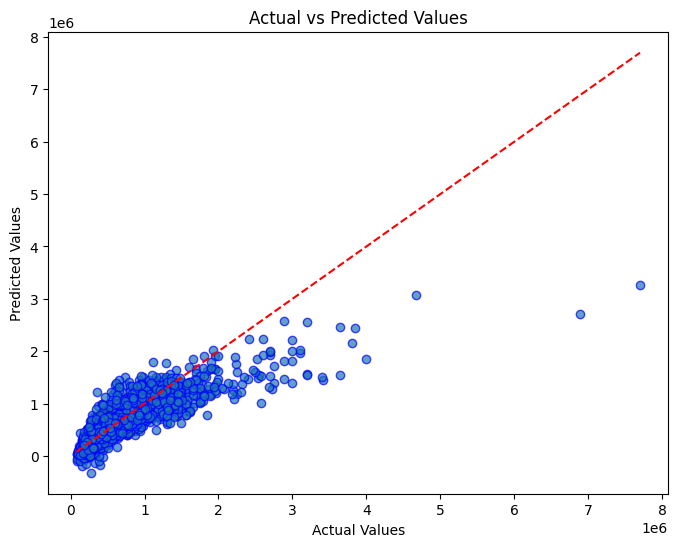

In [46]:
# Линейная регрессия
model_l = LinearRegression()

# объявление списка предикторов
predictor_features = [
     'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors',
     'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15',
     'sqft_lot15',
     'Year',
     'Month', 'Day'
]

# разделение на независимые и зависимую переменную
X = df[predictor_features]
y = df['price']

# разделение на тестовое и тренировочную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

# создание прогнозных значений
model_l.fit(X_train, y_train)

y_pred = model_l.predict(X_test)

# подсчет метрик
calculate_metrics(y_test, y_pred)

# рисование графика
draw_plot(y_test, y_pred)

R² Score for Happiness Score Prediction: 0.697949804072338
RMSE Score for Happiness Score Prediction: 42111821861.51094


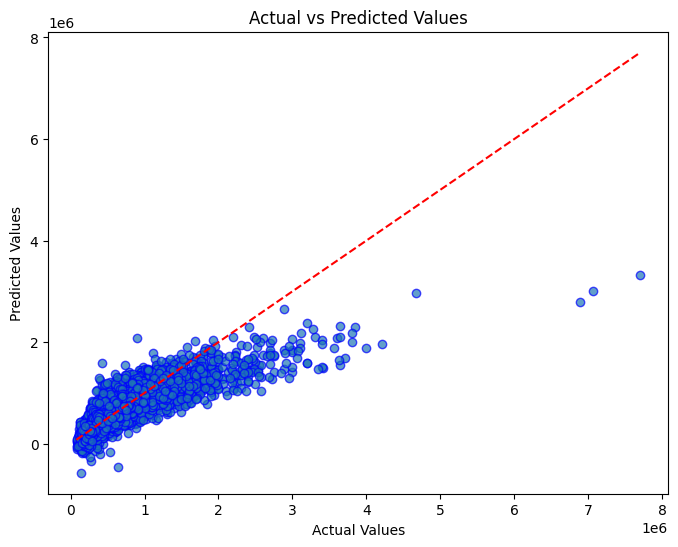

In [ ]:
# Добавляем константу для intercept (важно для statsmodels!)
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Модель OLS
model = sm.OLS(y_train, X_train_sm).fit()

# Предсказания
y_pred_ols = model.predict(X_test_sm)

# подсчет метрик
calculate_metrics(y_test, y_pred_ols)

# рисование графика
draw_plot(y_test, y_pred_ols)

In [ ]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     924.4
Date:                Fri, 28 Mar 2025   Prob (F-statistic):               0.00
Time:                        08:44:25   Log-Likelihood:                -78245.
No. Observations:                5747   AIC:                         1.565e+05
Df Residuals:                    5731   BIC:                         1.566e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.619e+07   1.27e+07     -4.425

In [ ]:
calculate_t_stats_and_p_values(model_l, X_train, y_train)

<ipython-input-75-9f0ad1ef9416>:47: RuntimeWarning: invalid value encountered in sqrt
  standard_errors = np.sqrt(np.diagonal(mse * X_inv))


,Predictor,Coefficient,Standard Error,t-Statistic,p-Value
0,bedrooms,-33026.686500,3756.698807,-8.791412,0.000000e+00
1,bathrooms,39780.891594,6018.058419,6.610253,4.183875e-11
2,sqft_living,104.648430,NaN,NaN,NaN
3,waterfront,424474.215293,33752.808402,12.575967,0.000000e+00
4,view,55210.388433,3970.759110,13.904240,0.000000e+00
5,condition,25822.988768,4504.004301,5.733340,1.034987e-08
6,grade,104141.141358,4056.365108,25.673513,0.000000e+00
7,sqft_above,69.090100,NaN,NaN,NaN
8,sqft_basement,35.558330,NaN,NaN,NaN
9,yr_built,-2495.825503,134.889517,-18.502739,0.000000e+00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19157 entries, 1 to 21612
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             19157 non-null  int64         
 1   date           19157 non-null  datetime64[ns]
 2   price          19157 non-null  float64       
 3   bedrooms       19157 non-null  float64       
 4   bathrooms      19157 non-null  float64       
 5   sqft_living    19157 non-null  float64       
 6   sqft_lot       19157 non-null  float64       
 7   floors         19157 non-null  float64       
 8   waterfront     19157 non-null  int64         
 9   view           19157 non-null  int64         
 10  condition      19157 non-null  int64         
 11  grade          19157 non-null  int64         
 12  sqft_above     19157 non-null  float64       
 13  sqft_basement  19157 non-null  int64         
 14  yr_built       19157 non-null  int64         
 15  yr_renovated   19157 non

# Прогноз стоимости поездки в такси NYC

In [ ]:
df_tips = pd.read_csv("/content/drive/MyDrive/Занятия АД 2 семестр 2025/Ресурсы/Данные/Занятие 5/Taxi_Trip_Data_preprocessed.csv")

df_tips

,passenger_count,trip_distance,payment_type,fare_amount,duration
0,1,3.70,Card,24.0,27.950000
1,1,2.77,Card,18.4,19.200000
2,1,3.30,Card,22.6,27.383333
3,1,0.30,Cash,5.1,2.550000
4,1,0.83,Card,7.2,5.250000
...,...,...,...,...,...
8451085,1,1.00,Card,15.6,17.333333
8451086,2,2.84,Card,25.4,29.550000
8451087,1,0.74,Cash,6.5,4.900000
8451088,1,0.73,Card,5.8,2.683333


In [ ]:
df_tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8451090 entries, 0 to 8451089
Data columns (total 5 columns):
 #   Column           Dtype  
---  ------           -----  
 0   passenger_count  int64  
 1   trip_distance    float64
 2   payment_type     object 
 3   fare_amount      float64
 4   duration         float64
dtypes: float64(3), int64(1), object(1)
memory usage: 322.4+ MB


R² Score for Happiness Score Prediction: 0.9738818428758818
RMSE Score for Happiness Score Prediction: 0.7452974050443709


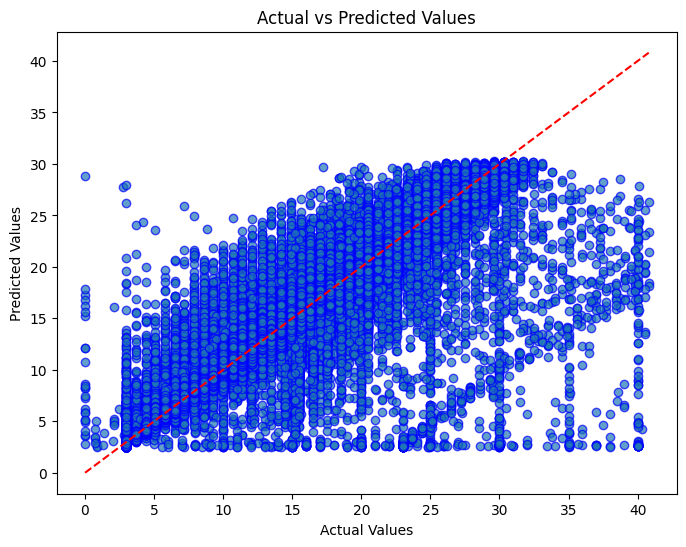

In [ ]:
encoder = LabelEncoder()

df_tips['payment_type'] = encoder.fit_transform(df_tips['payment_type'])

X = df_tips.drop('fare_amount', axis=1)
y = df_tips['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Calculate the R2 Score as a measure of prediction accuracy
calculate_metrics(y_test, y_pred)

# Plotting actual vs predicted values
draw_plot(y_test, y_pred)

R² Score for Happiness Score Prediction: 0.9738818428758818
RMSE Score for Happiness Score Prediction: 0.7452974050443708


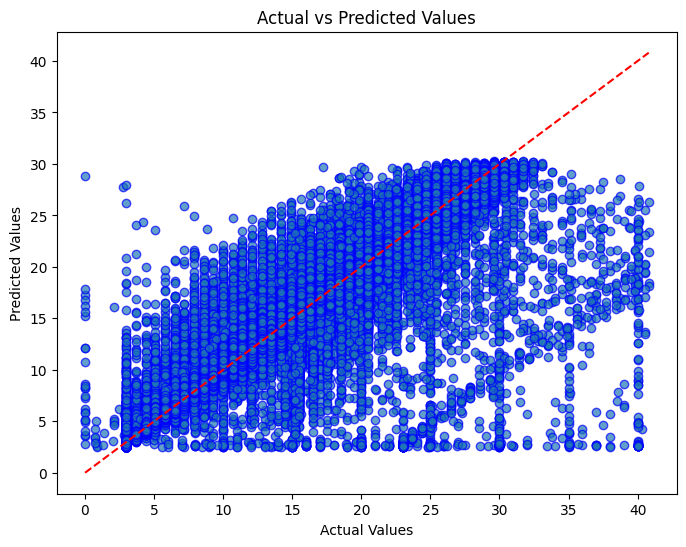

In [ ]:
# Добавляем константу для intercept (важно для statsmodels!)
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Модель OLS
model = sm.OLS(y_train, X_train_sm).fit()

# Предсказания
y_pred_ols = model.predict(X_test_sm)

# подсчет метрик
calculate_metrics(y_test, y_pred_ols)

# рисование графика
draw_plot(y_test, y_pred_ols)

In [ ]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                 5.536e+07
Date:                Fri, 28 Mar 2025   Prob (F-statistic):               0.00
Time:                        08:32:33   Log-Likelihood:            -7.5210e+06
No. Observations:             5915763   AIC:                         1.504e+07
Df Residuals:                 5915758   BIC:                         1.504e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.4411      0.001   24

KeyboardInterrupt: 

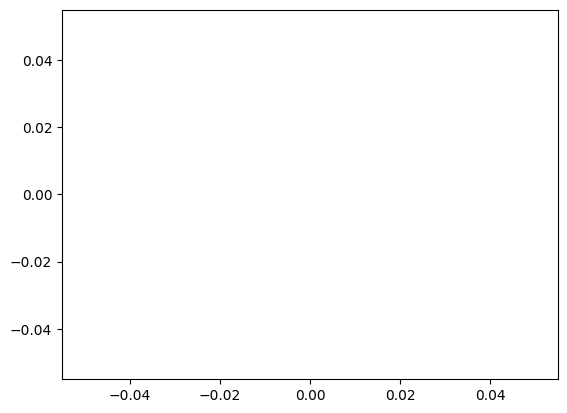

In [ ]:
sns.histplot(df_tips['trip_distance'], kde=True)
plt.title("Гистограмма данных")
plt.show()

In [ ]:
sns.histplot(df_tips['duration'], kde=True)
plt.title("Гистограмма данных")
plt.show()

In [ ]:
sns.histplot(df_tips['fare_amount'], kde=True)
plt.title("Гистограмма данных")
plt.show()

In [ ]:
sm.qqplot(df_tips['fare_amount'], line='45')
plt.title("Q-Q Plot")
plt.show()

In [ ]:
sm.qqplot(df_tips['duration'], line='45')
plt.title("Q-Q Plot")
plt.show()

In [ ]:
from scipy.stats import skew

skewness = skew(df_tips['duration'])
print(f"Коэффициент асимметрии duration: {skewness}")

skewness1 = skew(df_tips['fare_amount'])
print(f"Коэффициент асимметрии fare_amount: {skewness1}")

skewness2 = skew(df_tips['trip_distance'])
print(f"Коэффициент асимметрии trip_distance: {skewness2}")

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_tips, palette="coolwarm")  # Цветовая палитра
plt.title("Боксплоты с цветовой палитрой")
plt.xticks(rotation=45)
plt.show()

In [ ]:
df_fare_cit = df_tips.copy()

for col in ['trip_distance', 'fare_amount', 'duration']:

  Q1 = df_tips[col].quantile(0.25)
  Q3 = df_tips[col].quantile(0.75)
  IQR = Q3 - Q1

  df_fare_cit = df_fare_cit.loc[(df_fare_cit[col] < Q3 + 1.5 * IQR) & (df_fare_cit[col] > Q1 - 1.5 * IQR)]

df_fare_cit